# Step-1: Loading the Dataset

In [1]:
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2025-04-16 20:42:19.398818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744816339.451956   33073 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744816339.463941   33073 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744816339.584366   33073 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744816339.584398   33073 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744816339.584400   33073 computation_placer.cc:177] computation placer alr

In [2]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
import glob 
filePaths = glob.glob("/home/prakhar/Desktop/College/3rdYear/SEM-VI/MinorProject/Datasets/archive-2/*.csv")
df_list = [pd.read_csv(file,low_memory=False) for file in filePaths]
df=pd.concat(df_list,ignore_index=True)
print(df.shape)
print(df.head())

(2830743, 79)
    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6   

In [3]:
df = pd.read_csv("final_ds.csv") #Only Run this if you have already done all the pre processing

In [4]:
df.columns = df.columns.str.strip()
df['Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

# Step-2: Pre-Processing

In [5]:
df.dtypes #Viewing Datatype

Destination Port                 int64
Flow Duration                    int64
Total Fwd Packets                int64
Total Backward Packets           int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
Idle Std                       float64
Idle Max                         int64
Idle Min                         int64
Label                           object
Length: 79, dtype: object

In [6]:
is_inf = df.isin([np.inf, -np.inf])

inf_counts = is_inf.sum()

# Filter to show only columns with infinite values
columns_with_inf = inf_counts[inf_counts > 0]
print("Columns with infinite values:\n", columns_with_inf)

nan_counts = df.isnull().sum()

# Filter to show only columns with NaN values
columns_with_nan = nan_counts[nan_counts > 0]
print("\nColumns with NaN values:\n", columns_with_nan)

combined_counts = nan_counts + inf_counts

# Filter to show only columns with any NaN or inf values
columns_with_nan_or_inf = combined_counts[combined_counts > 0]
print("\nColumns with NaN or infinite values:\n", columns_with_nan_or_inf)

duplicate_rows_count = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_rows_count)

Columns with infinite values:
 Flow Bytes/s      1509
Flow Packets/s    2867
dtype: int64

Columns with NaN values:
 Flow Bytes/s    1358
dtype: int64

Columns with NaN or infinite values:
 Flow Bytes/s      2867
Flow Packets/s    2867
dtype: int64

Number of duplicate rows: 308381


In [7]:
df.replace([np.inf, -np.inf], np.nan, inplace=True) #Replacing inf values
df.dropna(inplace=True) #Replacing NaN values
df.drop_duplicates(inplace=True) #Removing duplicates to improve accuracy
category_mapping = {
    'BENIGN': 'BENIGN',
    'Bot': 'BOTNET',
    'DDoS': 'DOS',
    'DoS GoldenEye': 'DOS',
    'DoS Hulk': 'DOS',
    'DoS Slowhttptest': 'DOS',
    'DoS slowloris': 'DOS',
    'FTP-Patator': 'BRUTE_FORCE',
    'SSH-Patator': 'BRUTE_FORCE',
    'Heartbleed': 'WEB_ATTACK',
    'Infiltration': 'WEB_ATTACK',
    'PortScan': 'RECONNAISSANCE',
    'Web Attack � Brute Force': 'WEB_ATTACK',
    'Web Attack � Sql Injection': 'WEB_ATTACK',
    'Web Attack � XSS': 'WEB_ATTACK'
}
#Applying Mapping to simplify labels
df['Label'] =df['Label'].map(category_mapping)

In [8]:
print(df['Label'].value_counts())  # Before encoding

Label
BENIGN            2095057
DOS                321759
RECONNAISSANCE      90694
BRUTE_FORCE          9150
WEB_ATTACK           2190
BOTNET               1948
Name: count, dtype: int64


In [9]:
from sklearn.preprocessing import LabelEncoder #After Encoding
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

In [10]:
print(df['Label'].value_counts())  # Before encoding

Label
0    2095057
3     321759
4      90694
2       9150
5       2190
1       1948
Name: count, dtype: int64


In [11]:
import pandas as pd

# Get class counts
class_counts = df['Label'].value_counts()

# Select classes with more than 5000 samples
selected_classes = class_counts[class_counts > 50000].index.tolist()

# Manually include "WEB_ATTACK" and "BOTNET" if they exist in the dataset
for attack in [1, 5, 2]:
    if attack in df['Label'].values and attack not in selected_classes:
        selected_classes.append(attack)

# Select rows where 'Label' is in selected_classes
selected = df[df['Label'].isin(selected_classes)]

dfs = []
for name in selected_classes:
    df_class = selected[selected['Label'] == name]

    # Downsample if the class has more than 5000 samples
    if len(df_class) > 50000:
        df_class = df_class.sample(n=50000, random_state=0)

    dfs.append(df_class)

# Combine all sampled data
balanced_df = pd.concat(dfs, ignore_index=True)

# Check final class distribution
print(balanced_df['Label'].value_counts())

Label
0    50000
3    50000
4    50000
2     9150
5     2190
1     1948
Name: count, dtype: int64


In [12]:
balanced_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,62874,4,2,116,186,29,29,29.000,0.000000,...,20,0.00000,0.00000,0,0,0.000,0.00000,0,0,0
1,57225,86,1,1,0,0,0,0,0.000,0.000000,...,32,0.00000,0.00000,0,0,0.000,0.00000,0,0,0
2,80,116003861,16,14,440,412,356,0,27.500,87.612784,...,20,46441.09091,31255.09835,140678,36852,9995557.727,14892.00092,10000000,9950679,0
3,443,5683083,8,6,397,3716,216,0,49.625,79.224703,...,20,269399.00000,0.00000,269399,269399,5413681.000,0.00000,5413681,5413681,0
4,53,23652,1,1,48,128,48,48,48.000,0.000000,...,20,0.00000,0.00000,0,0,0.000,0.00000,0,0,0


In [13]:
from imblearn.over_sampling import SMOTE

x = balanced_df.drop('Label', axis=1)
y = balanced_df['Label']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(x, y)

blnc_data = pd.DataFrame(X_upsampled)
blnc_data['Label'] = y_upsampled
blnc_data = blnc_data.sample(frac=1)

print(blnc_data['Label'].value_counts())
blnc_data.head()

Label
0    50000
3    50000
4    50000
5    50000
1    50000
2    50000
Name: count, dtype: int64


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
4941,443,117843989,12,11,655,5381,206,0,54.583333,70.700982,...,20,133856.5,87195.45851,195513,72200,58700000.0,273366.0674,58900000,58600000,0
51775,80,5003551,8,6,397,11632,397,0,49.625000,140.360696,...,32,0.0,0.00000,0,0,0.0,0.0000,0,0,3
115253,5001,55,1,1,0,6,0,0,0.000000,0.000000,...,40,0.0,0.00000,0,0,0.0,0.0000,0,0,4
299321,80,5138140,3,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.00000,0,0,0.0,0.0000,0,0,5
173570,8080,87939,4,3,206,134,194,0,51.637068,95.316111,...,20,0.0,0.00000,0,0,0.0,0.0000,0,0,1


In [14]:
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
x = blnc_data.drop('Label',axis=1)
y = blnc_data['Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
n_components = 20
ipca = IncrementalPCA(n_components=n_components, batch_size=500)
x_pca = ipca.fit_transform(X_scaled) 
print(f"Explained Variance Ratio: {sum(ipca.explained_variance_ratio_):.4f}")
x = x_pca

Explained Variance Ratio: 0.9316


In [ ]:
# Replace original features with PCA-transformed data
for i in range(x_pca.shape[1]):
    blnc_data[f'PC{i+1}'] = x_pca[:, i]

# Drop the original feature columns (except 'Label')
blnc_data = blnc_data.drop(columns=blnc_data.columns.difference(
    ['Label', *blnc_data.columns[-n_components:]]))

# Save to CSV
blnc_data.to_csv('final_ds.csv', index=False)

print("Dataset saved as final_ds.csv")

In [4]:
x = df.drop('Label', axis=1) #Only run if all pre-processing is done, and if you have saved final_ds.csv
y = df['Label']

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,shuffle=True,random_state=42)

# Step-3: DL Algorithms

In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
import tensorflow as tf
import keras
from keras import layers,regularizers,optimizers,callbacks

#### Step-3.3: Applying DNN

In [17]:
model = keras.Sequential()
model.add(layers.Input(shape=(x_train.shape[1],)))  # Input layer

model.add(layers.Dense(128, activation='relu'))  # Hidden layer
model.add(layers.Dropout(0.1))  # Dropout layer

model.add(layers.Dense(256, activation='relu'))  # Hidden layer
model.add(layers.Dropout(0.1))  # Dropout layer

model.add(layers.Dense(128, activation='relu'))  # Hidden layer
model.add(layers.Dropout(0.1))  # Dropout layer

model.add(layers.Dense(6, activation='softmax'))  # Output layer

2025-04-16 19:21:14.981184: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-16 19:21:14.981221: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-04-16 19:21:14.981227: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-04-16 19:21:14.981232: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-04-16 19:21:14.981237: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: fedora
2025-04-16 19:21:14.981241: I external/local_xla/xla/stream_executor/cuda/cuda_d

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,382 (271.02 KB)

 Trainable params: 69,382 (271.02 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
early_stopping = keras.callbacks.EarlyStopping(
    verbose=1, restore_best_weights=True, patience=3)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="Models/Test/dnn_best_reference.keras", save_best_only=True)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[
              'accuracy'])  # compiling model

In [20]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, callbacks=[
          early_stopping, model_checkpoint],validation_data=(x_test,y_test))  # Fitting Model
model.save("Models/Final/DNN_reference.h5")  # Saving the model

Epoch 1/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8620 - loss: 0.4676 - val_accuracy: 0.9598 - val_loss: 0.1246
Epoch 2/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9617 - loss: 0.1291 - val_accuracy: 0.9711 - val_loss: 0.1021
Epoch 3/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9696 - loss: 0.1027 - val_accuracy: 0.9736 - val_loss: 0.0855
Epoch 4/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9732 - loss: 0.0903 - val_accuracy: 0.9755 - val_loss: 0.0782
Epoch 5/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9754 - loss: 0.0829 - val_accuracy: 0.9768 - val_loss: 0.0748
Epoch 6/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9762 - loss: 0.0785 - val_accuracy: 0.9780 - val_loss: 0.0721
Epoch 7/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9777 - loss: 0.0739 - val_accuracy: 0.9788 - val_loss: 0.0690
Epoch 8/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9781 - loss: 0

In [21]:
print(f"Result of Prediction") #Performing Predictions
predictions=model.predict(x=x_test)
print(predictions)
print("predictions shape:", predictions.shape)

Result of Prediction
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step
[[4.10376262e-04 9.99589145e-01 2.09957385e-08 1.68323648e-08
  3.33646113e-07 6.62013688e-09]
 [2.81852167e-02 1.15403367e-04 1.19451420e-06 7.57486802e-08
  9.71697509e-01 6.11820496e-07]
 [1.23701598e-02 9.87465739e-01 6.73565155e-05 8.88770774e-06
  1.16111287e-05 7.62116106e-05]
 ...
 [2.64566352e-05 9.99973476e-01 3.97883504e-08 1.30483295e-08
  1.58416906e-08 9.11836384e-09]
 [1.06685011e-05 7.28626675e-18 9.99988973e-01 2.24749019e-09
  2.19282717e-10 3.40162558e-07]
 [9.99999940e-01 6.64766506e-12 2.02226008e-23 1.89106413e-12
  2.77253372e-12 1.24956848e-13]]
predictions shape: (75000, 6)


#### Step-3.4: Applying DCNN

In [8]:
x_test.shape
x_train.shape

(225000, 20)

In [9]:
x_train.shape

(225000, 20)

In [10]:
x_train_np = x_train.to_numpy() #Only do this if loading final_ds.csv
x_test_np = x_test.to_numpy()

# Reshape for models that expect 3D input (e.g., LSTM, CNN)
x_train_reshaped = x_train_np.reshape(
    x_train_np.shape[0], x_train_np.shape[1], 1)
x_test_reshaped = x_test_np.reshape(x_test_np.shape[0], x_test_np.shape[1], 1)

In [7]:
x_train_reshaped = x_train.reshape(
    x_train.shape[0], x_train.shape[1], 1)

x_test_reshaped = x_test.reshape(
    x_test.shape[0], x_test.shape[1], 1)

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [25]:
x_train_reshaped.shape

(225000, 20, 1)

In [26]:
x_test_reshaped.shape

(75000, 20, 1)

In [27]:
# Create the model as before
model_cnn = keras.Sequential()

model_cnn.add(layers.Input(shape=(x_train_reshaped.shape[1], 1)))
model_cnn.add(layers.Conv1D(128, 20, data_format='channels_last',
                            activation='relu', padding='same'))
model_cnn.add(layers.Conv1D(256, 20, data_format='channels_last',
                            activation='relu', padding='same'))

model_cnn.add(layers.Flatten())

model_cnn.add(layers.Dense(256, activation='relu',
                           kernel_regularizer=keras.regularizers.l1_l2()))

model_cnn.add(layers.Dense(6, activation='softmax'))

In [28]:
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 128)        │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 256)        │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,310,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,970,822 (7.52 MB)

 Trainable params: 1,970,822 (7.52 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
callback = keras.callbacks.EarlyStopping(
    verbose=1, restore_best_weights=True, patience=3)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="Models/Test/cnn_best_reference.keras", save_best_only=True)
model_cnn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[
                  'accuracy'])  # compiling model

In [30]:
history = model_cnn.fit(x_train_reshaped, y_train, epochs=50, batch_size=32, callbacks=[
              early_stopping, model_checkpoint], validation_data=(x_test_reshaped, y_test))  # Fitting Model
model_cnn.save("Models/Final/CNN_reference.h5")  # Saving the model

Epoch 1/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.9342 - loss: 0.2488 - val_accuracy: 0.9713 - val_loss: 0.1003
Epoch 2/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.9753 - loss: 0.0848 - val_accuracy: 0.9763 - val_loss: 0.0810
Epoch 3/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.9786 - loss: 0.0715 - val_accuracy: 0.9787 - val_loss: 0.0723
Epoch 4/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.9799 - loss: 0.0650 - val_accuracy: 0.9797 - val_loss: 0.0689
Epoch 5/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.9809 - loss: 0.0608 - val_accuracy: 0.9805 - val_loss: 0.0645
Epoch 6/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.9817 - loss: 0.0582 - val_accuracy: 0.9812 - val_loss: 0.0617
Epoch 7/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.9824 - loss: 0.0562 - val_accuracy: 0.9818 - val_loss: 0.0591
Epoch 8/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 

In [31]:
print(f"Result of Prediction")  # Performing Predictions
predictions = model_cnn.predict(x=x_test_reshaped)
print(predictions)
print("predictions shape:", predictions.shape)

Result of Prediction
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
[[1.8734060e-04 9.9981236e-01 1.0757112e-15 1.0029067e-07 2.5559712e-07
  1.8269366e-09]
 [2.9535115e-02 4.2784861e-05 1.0289765e-09 4.2792527e-07 9.7042161e-01
  2.3232436e-09]
 [9.8187281e-03 9.9017227e-01 9.9129363e-07 1.9543807e-06 4.3913760e-06
  1.6783505e-06]
 ...
 [7.2936825e-07 9.9999923e-01 2.3345562e-18 7.8441351e-11 2.0644595e-14
  1.3997775e-17]
 [1.1789464e-05 1.5381053e-18 9.9998802e-01 3.0919435e-13 2.6128398e-14
  1.0786435e-07]
 [9.9999994e-01 2.0521228e-17 3.5082830e-30 3.8575515e-15 3.2869688e-12
  3.6054441e-28]]
predictions shape: (75000, 6)


In [32]:
print(f"Results of Testing")  # Testing the model
model_cnn.evaluate(x_test_reshaped, y_test)

Results of Testing
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9857 - loss: 0.0488


[0.04747077077627182, 0.9861066937446594]

# Step-4: Loading and Evaluating Model

In [11]:
model =  keras.models.load_model('Models/Final/DNN_reference.h5')
model_2 = keras.models.load_model('Models/Final/CNN_reference.h5')

2025-04-16 20:45:47.065880: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-16 20:45:47.065912: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-04-16 20:45:47.065919: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-04-16 20:45:47.065923: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-04-16 20:45:47.065929: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: fedora
2025-04-16 20:45:47.065932: I external/local_xla/xla/stream_executor/cuda/cuda_d

#### Step-4.1: DNN

In [12]:
y_pred = model.predict(x_test) #For DNN
y_pred_class = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_class))

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 661us/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     12487
           1       0.98      1.00      0.99     12623
           2       1.00      0.98      0.99     12463
           3       0.99      1.00      0.99     12491
           4       0.98      1.00      0.99     12487
           5       0.98      1.00      0.99     12449

    accuracy                           0.99     75000
   macro avg       0.99      0.99      0.99     75000
weighted avg       0.99      0.99      0.99     75000



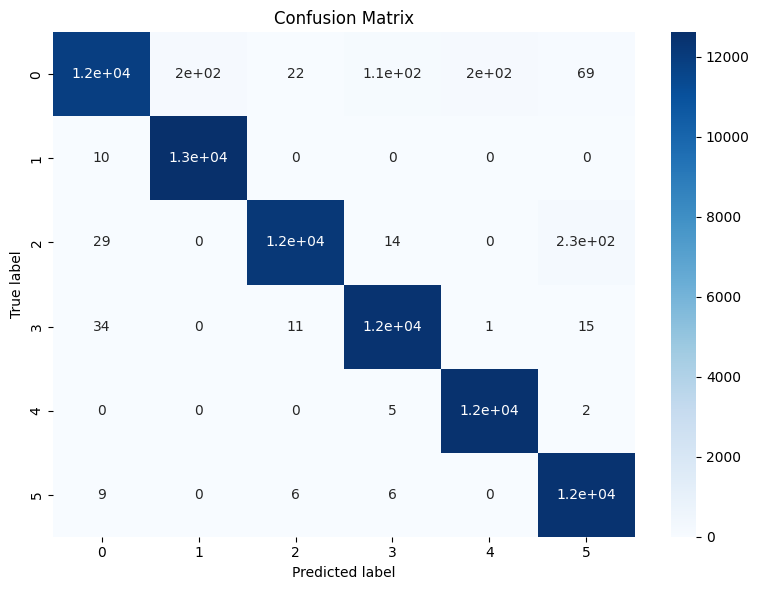

In [13]:
# Compute ROC curve
# False Positive Rate, True Positive Rate
conf_mtr = confusion_matrix(y_true=y_test, y_pred=y_pred_class)
# Creating a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mtr, annot=True, cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

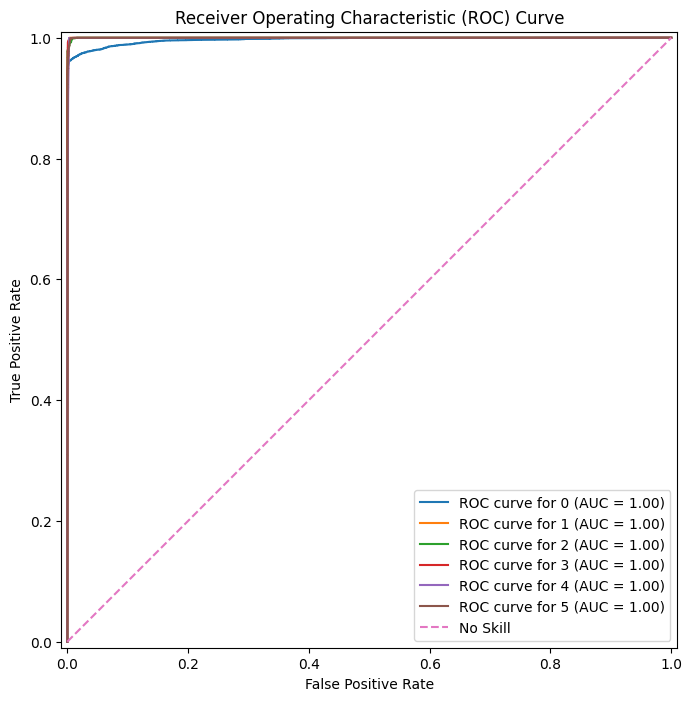

In [36]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(lb.classes_):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_pred[:, i],  # Use probability scores for class i
        name=f'ROC curve for {class_name}',
        ax=plt.gca()
    )


plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#### Step-4.2: CNN

In [37]:
y_pred = model_2.predict(x_test_reshaped)  # For CNN
y_pred_class = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_class))

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     12487
           1       0.98      1.00      0.99     12623
           2       1.00      0.98      0.99     12463
           3       0.98      1.00      0.99     12491
           4       0.98      1.00      0.99     12487
           5       0.98      1.00      0.99     12449

    accuracy                           0.99     75000
   macro avg       0.99      0.99      0.99     75000
weighted avg       0.99      0.99      0.99     75000



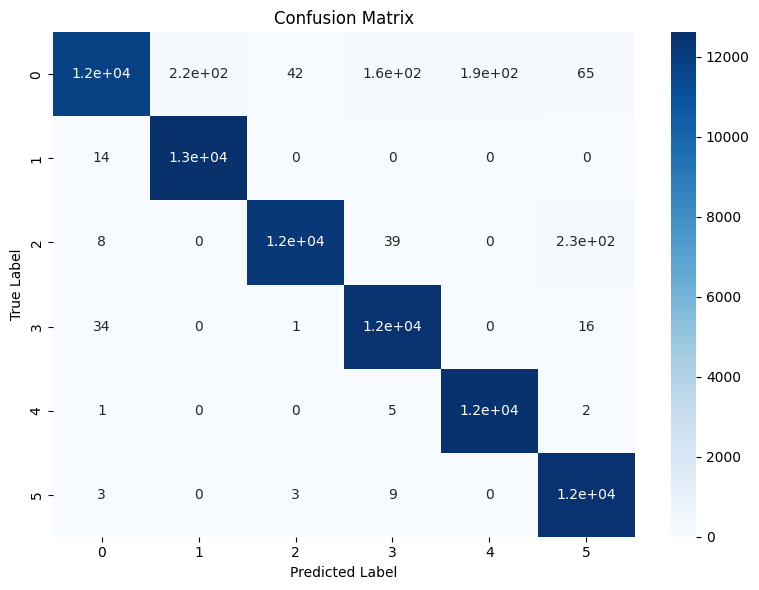

In [38]:
conf_mtr = confusion_matrix(y_true=y_test, y_pred=y_pred_class)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mtr, annot=True, cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

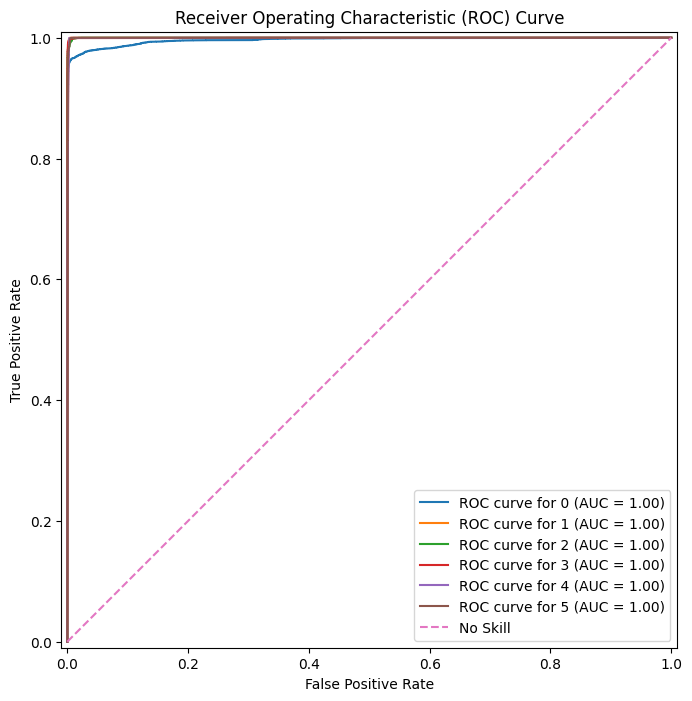

In [39]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(lb.classes_):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_pred[:, i],  # Use probability scores for class i
        name=f'ROC curve for {class_name}',
        ax=plt.gca()
    )


plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()